<a href="https://colab.research.google.com/github/brunocosouza/supervised_learning/blob/main/MO432_Exerc%C3%ADcio3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>MO432 - Atividade 2</h1>

RA234837 - Bruno César de Oliveira Souza

RA065068 - Walker Humberto Batista

https://www.tensorflow.org/tutorials/structured_data/time_series

# Gold price forecast

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

import IPython
import IPython.display

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Reading data into Series pandas dataframe
df_raw = pd.read_csv('https://www.ic.unicamp.br/~wainer/cursos/1s2021/432/ouro2.csv', index_col = 0)

In [ ]:
# Invert Series
df_raw.index = pd.to_datetime(df_raw.index, format='%d/%m/%Y')
df_raw

,Valor
Data,
2021-06-13,1868.0
2021-06-06,1879.6
2021-05-30,1892.0
2021-05-23,1905.3
2021-05-16,1878.9
...,...
2000-07-16,280.1
2000-07-09,281.1
2000-07-02,283.2


In [ ]:
df = df_raw.sort_values('Data')
df['Valor']

Data
2000-06-18     282.7
2000-06-25     290.1
2000-07-02     283.2
2000-07-09     281.1
2000-07-16     280.1
               ...  
2021-05-16    1878.9
2021-05-23    1905.3
2021-05-30    1892.0
2021-06-06    1879.6
2021-06-13    1868.0
Name: Valor, Length: 1096, dtype: float64

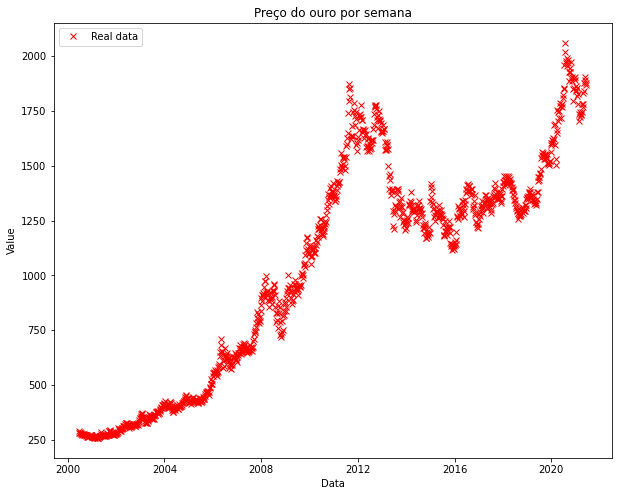

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(df.index.values, df.values, 'rx', linewidth=1, label="Real data")
plt.title('Preço do ouro por semana')
plt.xlabel('Data')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Divisão 70%, 20% e 10%
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.909)]
test_df = df[int(n*0.909):]

num_features = df.shape[1]
df

,Valor
Data,
2000-06-18,282.7
2000-06-25,290.1
2000-07-02,283.2
2000-07-09,281.1
2000-07-16,280.1
...,...
2021-05-16,1878.9
2021-05-23,1905.3
2021-05-30,1892.0


In [ ]:
#Normalize 
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
def desnormalization(inputs):
    return inputs * train_std + train_mean

In [ ]:
print('All shapes are :')
print(f'Train: {train_df.shape}')
print(f'Val: {val_df.shape}')
print(f'Test: {test_df.shape}')

All shapes are :
Train: (767, 1)
Val: (229, 1)
Test: (100, 1)


In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='Valor', max_subplots=3):
    inputs, labels = self.example
    inputs = desnormalization(inputs)
    labels = desnormalization(labels)
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(1):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [week]')

  def plot_prediction(self, model=None, plot_col='Valor', max_subplots=3):
    inputs, labels = next(iter(self.test))
    inputs_des = desnormalization(inputs)
    labels_des = desnormalization(labels)
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs_des[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels_des[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        predictions = desnormalization(predictions, train=False)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [week]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
wide_window = WindowGenerator(
    input_width=99, label_width=99, shift=1,
    label_columns=['Valor'])

In [ ]:
x , y = next(iter(wide_window.test))
inputs_s = desnormalization(x)
inputs_s[0, :, 0]

<tf.Tensor: shape=(99,), dtype=float32, numpy=
array([1460.4   , 1485.3   , 1534.5   , 1549.2   , 1563.5   , 1557.2   ,
       1543.3   , 1530.7   , 1545.3   , 1548.3   , 1551.9   , 1529.8   ,
       1535.    , 1547.7   , 1554.4   , 1510.4   , 1513.6001, 1508.    ,
       1510.7   , 1504.2001, 1523.    , 1523.1001, 1561.2   , 1596.4   ,
       1603.3   , 1603.4   , 1615.4   , 1626.1001, 1612.8   , 1624.1001,
       1686.3   , 1596.6001, 1691.6   , 1532.2   , 1501.4   , 1661.    ,
       1650.1001, 1755.4   , 1705.6001, 1745.6001, 1717.8   , 1748.3   ,
       1786.2001, 1770.8   , 1773.8   , 1716.    , 1768.1001, 1782.1   ,
       1810.8   , 1825.    , 1852.    , 1854.3   , 1957.5   , 2017.1   ,
       2061.4   , 1976.8   , 1969.6   , 1993.2001, 1952.8   , 1967.4   ,
       1981.9   , 1884.8   , 1926.6001, 1947.8   , 1928.3   , 1926.4   ,
       1899.9   , 1973.    , 1906.3   , 1888.2   , 1797.5   , 1849.    ,
       1853.1   , 1898.2001, 1893.1   , 1905.8   , 1845.4   , 1839.    ,
    

In [ ]:
# Model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 99, 1)
Output shape: (32, 99, 1)


In [ ]:
val_performance = {}
performance = {}

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

5/5 [==============================] - 0s 8ms/step - loss: 0.0368 - mean_absolute_error: 0.1420


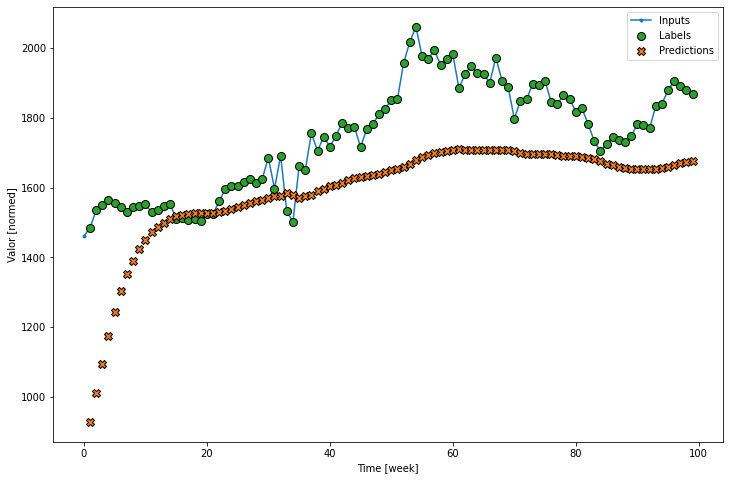

In [ ]:
wide_window.plot_prediction(lstm_model)

## Residual Wrapper

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

5/5 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_absolute_error: 0.0365



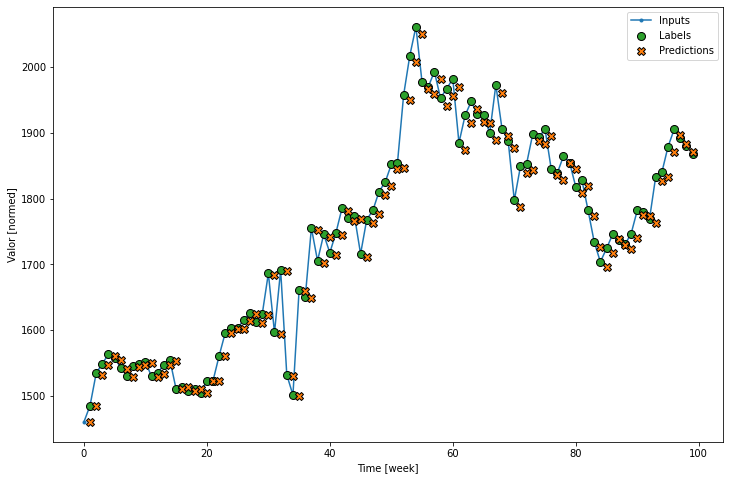

In [ ]:
wide_window.plot_prediction(residual_lstm)

## RNN

In [ ]:
rnn_model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
   tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(rnn_model, wide_window)

IPython.display.clear_output()
val_performance['RNN'] = rnn_model.evaluate(wide_window.val)
performance['RNN'] = rnn_model.evaluate(wide_window.test, verbose=0)
print()

5/5 [==============================] - 0s 6ms/step - loss: 0.0223 - mean_absolute_error: 0.0957



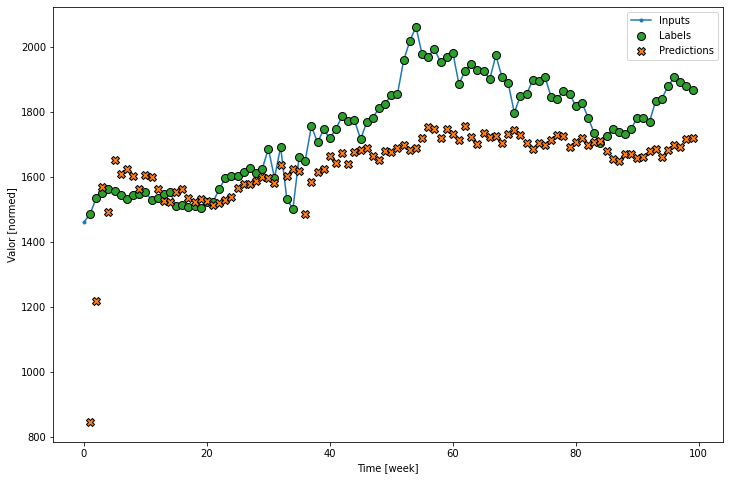

In [ ]:
wide_window.plot_prediction(rnn_model)

## GRU

In [ ]:
gru_model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(32, return_sequences=True),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])

history = compile_and_fit(gru_model, wide_window)

IPython.display.clear_output()
val_performance['GRU'] = gru_model.evaluate(wide_window.val)
performance['GRU'] = gru_model.evaluate(wide_window.test, verbose=0)
print()

5/5 [==============================] - 0s 9ms/step - loss: 0.0123 - mean_absolute_error: 0.0720



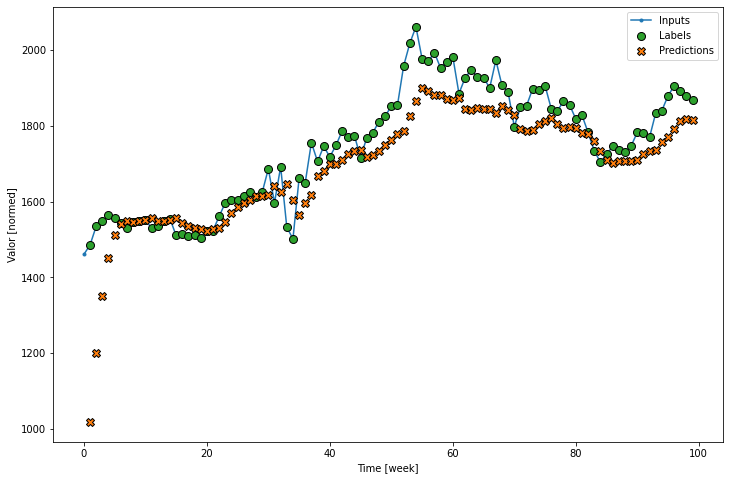

In [ ]:
wide_window.plot_prediction(gru_model)

## RSME Evaluation

In [ ]:
#LSTM
rmse = tf.keras.metrics.MeanSquaredError()
inputs = desnormalization(next(iter(wide_window.test))[0])
labels = desnormalization(next(iter(wide_window.test))[1])

mae = tf.keras.metrics.MeanAbsoluteError()

pred = lstm_model(next(iter(wide_window.test))[0])
pred = desnormalization(pred, train=False)

#Calculo RMSE
rmse.update_state(pred,labels)
mae.update_state(pred,labels)

import math
math.sqrt(rmse.result().numpy()), math.sqrt(mae.result().numpy())

(125.70326775162808, 10.181399525667851)

In [ ]:
#Residual LSTM
rmse = tf.keras.metrics.MeanSquaredError()
inputs = desnormalization(next(iter(wide_window.test))[0])
labels = desnormalization(next(iter(wide_window.test))[1])

mae = tf.keras.metrics.MeanAbsoluteError()

pred = residual_lstm(next(iter(wide_window.test))[0])
pred = desnormalization(pred)

#Calculo RMSE
rmse.update_state(pred,labels)
mae.update_state(pred,labels)

import math
math.sqrt(rmse.result().numpy()), math.sqrt(mae.result().numpy())

(29.54012040224119, 4.572903203690971)

In [ ]:
# RNN
rmse = tf.keras.metrics.MeanSquaredError()
inputs = desnormalization(next(iter(wide_window.test))[0])
labels = desnormalization(next(iter(wide_window.test))[1])

mae = tf.keras.metrics.MeanAbsoluteError()

pred = rnn_model(next(iter(wide_window.test))[0])
pred = desnormalization(pred)

#Calculo RMSE
rmse.update_state(pred,labels)
mae.update_state(pred,labels)

import math
math.sqrt(rmse.result().numpy()), math.sqrt(mae.result().numpy())

(104.08532970296534, 9.088367665254728)

In [ ]:
# GRU
rmse = tf.keras.metrics.MeanSquaredError()
inputs = desnormalization(next(iter(wide_window.test))[0])
labels = desnormalization(next(iter(wide_window.test))[1])

mae = tf.keras.metrics.MeanAbsoluteError()

pred = gru_model(next(iter(wide_window.test))[0])
pred = desnormalization(pred, train=False)

#Calculo RMSE
rmse.update_state(pred,labels)
mae.update_state(pred,labels)

import math
math.sqrt(rmse.result().numpy()), math.sqrt(mae.result().numpy())

(61.45371495712241, 6.588550705331827)

# Classification ----------------------------

In [ ]:
df_raw['oscilacao'] = (df_raw['Valor'] - df_raw['Valor'].shift()) / df_raw['Valor'].shift()
df_raw['classificacao'] = [1 if x  > 0 else 0 for x in df_raw['oscilacao']]
df_raw = df_raw.drop(['oscilacao'], axis=1)
df = df_raw
df

,Valor,classificacao
Data,,
2021-06-13,1.758711,0
2021-06-06,1.794895,1
2021-05-30,1.833575,1
2021-05-23,1.875062,1
2021-05-16,1.792712,0
...,...,...
2000-07-16,0.222871,1
2000-07-09,0.298884,1
2000-07-02,0.458512,1


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Valor,1096.0,1.009077e-15,0.999086,-2.231524,-0.572669,-0.013445,0.557928,3.016084
classificacao,1096.0,4.744526e-01,0.499575,0.000000,0.000000,0.000000,1.000000,1.000000


In [ ]:
# Divisão 70%, 20% e 10%
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.909)]
test_df = df[int(n*0.909):]

num_features = df.shape[1]

In [ ]:
#Normalize 
train_mean = train_df['Valor'].mean()
train_std = train_df['Valor'].std()

val_mean = val_df['Valor'].mean()
val_std = val_df['Valor'].std()

test_mean = test_df['Valor'].mean()
test_std = test_df['Valor'].std()

train_df['Valor'] = (train_df - train_mean) / train_std
val_df['Valor'] = (val_df - val_mean) / val_std
test_df['Valor'] = (test_df - test_mean) / test_std

In [ ]:
print('All shapes are :')
print(f'Train: {train_df.shape}')
print(f'Val: {val_df.shape}')
print(f'Test: {test_df.shape}')

All shapes are :
Train: (767, 2)
Val: (229, 2)
Test: (100, 2)


In [ ]:
class WindowGeneratorClass():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='Valor', max_subplots=3):
    inputs, labels = self.example
    inputs = desnormalization(inputs)
    labels = desnormalization(labels)
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [week]')

  def plot_prediction(self, model=None, plot_col='Valor', max_subplots=3):
    inputs, labels = next(iter(self.test))
    inputs_des = desnormalization(inputs, train=False)
    labels_des = desnormalization(labels, train=False)
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs_des[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels_des[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        predictions = desnormalization(predictions, train=False)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [week]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=1,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

In [ ]:
class_window = WindowGeneratorClass(train_df=train_df, val_df=val_df, test_df=test_df,
    input_width=99, label_width=99, shift=1,
    label_columns=['classificacao'])

In [ ]:
MAX_EPOCHS = 10

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

## LSTM Classification

In [ ]:
# Model
lstm_model_class = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units = 1, activation='sigmoid')
])


print('Input shape:', class_window.example[0].shape)
print('Output shape:', lstm_model_class(class_window.example[0]).shape)

Input shape: (1, 99, 2)
Output shape: (1, 99, 1)


In [ ]:
val_performance = {}
performance = {}

history = compile_and_fit(lstm_model_class, class_window)

IPython.display.clear_output()
val_performance['LSTM Class'] = lstm_model_class.evaluate(class_window.val)
performance['LSTM Class'] = lstm_model_class.evaluate(class_window.test, verbose=0)

labels = next(iter(class_window.test))[1][0]
pred = tf.convert_to_tensor(np.array([1 if x > 4.744526e-01 else 0 for x in lstm_model_class(next(iter(class_window.test))[0])[0]]).reshape(-1,1), dtype = tf.float32)

acc = tf.keras.metrics.Accuracy()
acc.update_state(pred, labels)
acc.result().numpy()

130/130 [==============================] - 1s 5ms/step - loss: 0.3038 - mean_absolute_error: 0.4757


0.4949495

## Residual Classification

In [ ]:
# Model residual Class
residual_lstm_class = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Dense(1, activation='sigmoid')
]))

history = compile_and_fit(residual_lstm_class, class_window)

IPython.display.clear_output()
val_performance['Residual LSTM Class'] = residual_lstm_class.evaluate(class_window.val)
performance['Residual LSTM Class'] = residual_lstm_class.evaluate(class_window.test, verbose=0)
print()

130/130 [==============================] - 1s 5ms/step - loss: 0.6699 - mean_absolute_error: 0.6599



In [ ]:
labels = next(iter(class_window.test))[1][0]
pred = tf.convert_to_tensor(np.array([1 if x[1] > 0.045 else 0 for x in residual_lstm_class(next(iter(class_window.test))[0])[0]]), dtype = tf.float32)

acc = tf.keras.metrics.Accuracy()
acc.update_state(pred, labels)
acc.result().numpy()

0.5151515

## RNN Classification

In [ ]:
rnn_model_class = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(32, return_sequences=True),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=1, activation='sigmoid')
])

print('Input shape:', class_window.example[0].shape)
print('Output shape:', rnn_model_class(class_window.example[0]).shape)

Input shape: (1, 99, 2)
Output shape: (1, 99, 1)


In [ ]:
history = compile_and_fit(rnn_model_class, class_window)

IPython.display.clear_output()
val_performance['RNN Class'] = rnn_model_class.evaluate(class_window.val)
performance['RNN Class'] = rnn_model_class.evaluate(class_window.test, verbose=0)
print()

130/130 [==============================] - 1s 4ms/step - loss: 0.3743 - mean_absolute_error: 0.5041



In [ ]:
labels = next(iter(class_window.test))[1][0]
pred = tf.convert_to_tensor(np.array([1 if x > 4.744526e-01 else 0 for x in rnn_model_class(next(iter(class_window.test))[0])[0]]).reshape(-1,1), dtype = tf.float32)

acc = tf.keras.metrics.Accuracy()
acc.update_state(pred, labels)
acc.result().numpy()

0.5151515

## GRU

In [ ]:
gru_model_class = tf.keras.models.Sequential([
  tf.keras.layers.GRU(32, return_sequences=True),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

history = compile_and_fit(gru_model_class, class_window)

IPython.display.clear_output()
val_performance['GRU'] = gru_model_class.evaluate(class_window.val)
performance['GRU'] = gru_model_class.evaluate(class_window.test, verbose=0)
print()

130/130 [==============================] - 1s 5ms/step - loss: 0.2531 - mean_absolute_error: 0.4906



In [ ]:
labels = next(iter(class_window.test))[1][0]
pred = tf.convert_to_tensor(np.array([1 if x > 4.744526e-01 else 0 for x in gru_model_class(next(iter(class_window.test))[0])[0]]).reshape(-1,1), dtype = tf.float32)

acc = tf.keras.metrics.Accuracy()
acc.update_state(pred, labels)
acc.result().numpy()

0.4949495